## Stark Broadening Asymmetries From SPY

[The SPY survey](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A.131N/abstract) has a ton of high-res WD spectra. I'm gonna see how much Stark broadening affects their absorption lines.

In [1]:
import glob
import os
import numpy as np

from astropy.io import ascii
from astropy.table import Table, join
import matplotlib.pyplot as plt
plt.style.use('../../proj/core-composition/notebooks/stefan.mplstyle')

In [2]:
from stark import cattools as ct
from stark import measure as meas

obj = ct.fetch_objfile()
sdss_wds = Table.read('./data/raw/25SDSS_inSPY.csv')
sdss_wds.remove_columns(['ra', 'dec'])
cat = join(obj, sdss_wds, keys_left='Name', keys_right='Name_2', join_type='inner')

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [3]:
spec, obj = ct.read_spectrum(cat, './data/raw/sp', download_files=True)

100%|██████████| 53/53 [00:29<00:00,  1.80it/s]


In [ ]:
measured = meas.analyze_spectra(spec, './data/processed/25SDSS_inSPY.json')
measured

HE0150p0045_a_2003_02_05T00_59_38_all.dat.gz


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


HE1124p0144_a_2000_07_01T23_28_54_all.dat.gz


100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


HE1124p0144_b_2000_07_02T23_34_34_all.dat.gz


100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


HE1258p0123_a_2000_06_08T00_27_45_all.dat.gz


100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


HE1258p0123_b_2000_07_02T02_25_08_all.dat.gz


100%|██████████| 10/10 [00:47<00:00,  4.80s/it]


HE1335m0332_a_2000_07_15T01_09_38_all.dat.gz


100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


HE1335m0332_b_2000_07_18T01_02_26_all.dat.gz


100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


HE1340m0530_a_2000_07_16T01_33_19_all.dat.gz


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


HE1340m0530_b_2000_07_18T01_16_16_all.dat.gz


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


HE1441m0047_a_2000_07_13T03_52_38_all.dat.gz


100%|██████████| 10/10 [00:51<00:00,  5.10s/it]


HE1441m0047_b_2000_07_16T01_18_32_all.dat.gz


100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


HS0130p0156_b_2001_08_22T08_54_07_all.dat.gz


100%|██████████| 10/10 [00:55<00:00,  5.54s/it]


HS0130p0156_a_2002_09_30T04_37_29_all.dat.gz


 60%|██████    | 6/10 [01:40<01:58, 29.74s/it]/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:149: RuntimeWarning: invalid value encountered in sqrt
  intersect = ( (-pcoef[1] + np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc - 1))) / (2 * pcoef[0]),
/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:150: RuntimeWarning: invalid value encountered in sqrt
  (-pcoef[1] - np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc - 1))) / (2 * pcoef[0]) )
100%|██████████| 10/10 [05:45<00:00, 34.51s/it]


HS0949p0823_a_2003_01_24T06_24_23_all.dat.gz


100%|██████████| 10/10 [00:49<00:00,  4.90s/it]


HS0949p0823_b_2003_01_24T06_38_52_all.dat.gz


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


HS0949p0823_b_2003_02_14T04_18_36_all.dat.gz


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


HS0949p0823_b_2003_02_14T04_29_58_all.dat.gz


100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


HS1003p0726_a_2002_05_24T01_56_20_all.dat.gz


100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


HS1003p0726_b_2003_01_17T04_55_02_all.dat.gz


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


HS1614p1136_b_2003_07_19T03_38_43_all.dat.gz


100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


HS1614p1136_a_2002_06_18T02_13_25_all.dat.gz


100%|██████████| 10/10 [01:13<00:00,  7.35s/it]


HS1616p0247_b_2002_09_24T23_59_54_all.dat.gz


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


HS1616p0247_a_2002_06_18T01_59_12_all.dat.gz


100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


HS1646p1059_b_2001_08_16T02_10_37_all.dat.gz


100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


HS1646p1059_a_2001_07_27T01_50_31_all.dat.gz


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


HS1648p1300_b_2001_07_27T01_36_07_all.dat.gz


100%|██████████| 10/10 [00:54<00:00,  5.44s/it]


HS1648p1300_a_2001_07_26T01_11_45_all.dat.gz


100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


HS2046p0044_b_2002_09_21T00_03_14_all.dat.gz


100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


HS2046p0044_a_2002_09_04T03_10_23_all.dat.gz


100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


HS2046p0044_a_2002_09_04T02_58_02_all.dat.gz


100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


WD0250m007_a_2003_02_04T00_59_57_all.dat.gz


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


WD0250m007_b_2003_01_16T02_54_48_all.dat.gz


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


WD1036p085_a_2001_04_10T05_36_08_all.dat.gz


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


WD1036p085_b_2003_01_17T05_40_51_all.dat.gz


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


WD1124m018_a_2002_02_23T07_58_46_all.dat.gz


100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


WD1124m018_b_2002_02_25T06_43_25_all.dat.gz


100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


WD1507p021_a_2002_06_18T01_25_27_all.dat.gz


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


WD1609p135_a_2000_06_06T06_01_01_all.dat.gz


100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


WD1609p135_b_2000_06_10T05_22_41_all.dat.gz


100%|██████████| 10/10 [08:02<00:00, 48.30s/it]


WD1614p136_a_2001_07_26T02_05_57_all.dat.gz


100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


WD1614p136_b_2001_07_27T00_37_31_all.dat.gz


100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


WD1736p052_a_2000_05_24T09_40_31_all.dat.gz


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


WD1736p052_b_2000_06_01T07_01_24_all.dat.gz


100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


WD1736p052_b_2000_07_05T04_22_56_all.dat.gz


100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


WD1840p042_b_2003_06_25T05_30_21_all.dat.gz


100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


WD1840p042_a_2002_04_23T09_21_04_all.dat.gz


100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


WD1857p119_a_2000_05_17T05_16_51_all.dat.gz


100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


WD1857p119_a_2000_05_26T09_12_01_all.dat.gz


 50%|█████     | 5/10 [00:30<00:33,  6.61s/it]

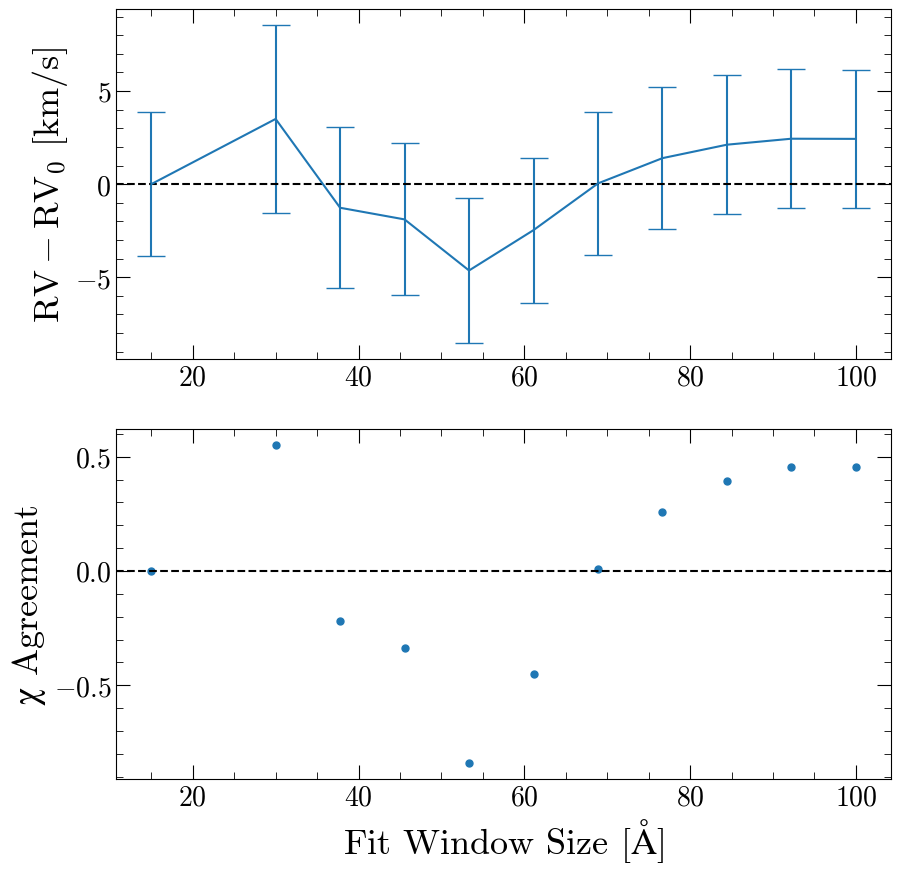

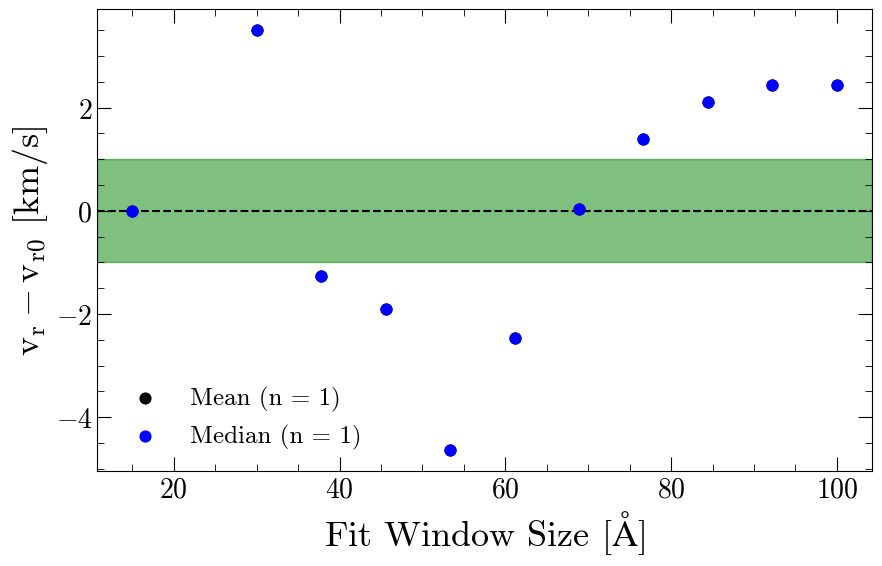

In [5]:
meas.plot_ensemble(measured)